In [104]:
import cv2
import numpy as np
import redis
import matplotlib.pyplot as plt
import glob
import struct
import time

# Getting frames from video

In [105]:
path = "./streams/xu76US-JqG8/20231203_143319.mp4"

In [106]:
def get_frames_from_video(video_path, fps: int = 1, frames_to_get: int = 10) -> list:
    """
    Get frames from video with specified fps.

    :param video_path: path to video.
    :param fps: frames per second.
    :param frames_to_get: number of frames to get.
    :return: list of frames.
    """

    frames = []
    retrieved_frames = 0

    video = cv2.VideoCapture(video_path)
    video_fps = int(video.get(cv2.CAP_PROP_FPS))
    video_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps_interval = video_fps // fps    

    for frame_i in range(0, video_frames, fps_interval):
        if retrieved_frames >= frames_to_get:
            break
        video.set(cv2.CAP_PROP_POS_FRAMES, frame_i)
        ret, frame = video.read()

        if ret:
            frames.append(frame)
            retrieved_frames += 1

    video.release()

    return frames

In [107]:
start_time = time.time()

frames = get_frames_from_video(path)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.869615077972412 seconds ---


# Getting frames from stored pictures

In [108]:
def get_frames_from_video_custom(video_path, fps: int = 1, frames_to_get: int = 10) -> list:
    """
    Get frames from video with specified fps.

    :param video_path: path to video.
    :param fps: frames per second.
    :param frames_to_get: number of frames to get.
    :return: list of frames.
    """

    retrieved_frames = 0

    video = cv2.VideoCapture(video_path)
    video_fps = int(video.get(cv2.CAP_PROP_FPS))
    video_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps_interval = video_fps // fps    

    for frame_i in range(0, video_frames, fps_interval):
        if retrieved_frames >= frames_to_get:
            break
        video.set(cv2.CAP_PROP_POS_FRAMES, frame_i)
        ret, frame = video.read()

        if ret:
            cv2.imwrite(f"./temp/{frame_i}_frame.png", frame)
            retrieved_frames += 1

    video.release()

In [110]:
start_time = time.time()

get_frames_from_video_custom(path)

print("--- %s seconds ---" % (time.time() - start_time))

--- 2.0536184310913086 seconds ---


In [111]:
start_time = time.time()

frame_dir_list = glob.glob("./temp/*.png")
frame_dir_list = sorted(
    [file_path.replace('\\', '/') for file_path in frame_dir_list],
    key=lambda x: int(x.split('_')[0].split('/')[-1])
)
frames2 = []
for frame_dir in frame_dir_list:
    frames2.append(cv2.imread(frame_dir))
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.3530235290527344 seconds ---



# Getting frames from redis

In [112]:
r = redis.Redis(
                host="asrock-server.external.baskorver.nl",
                password="bfq8*Y659Qfr031DeyKCwHAo9U%OeHl@",
            )

In [115]:
start_time = time.time()

for i, frame in enumerate(frames):
    h, w, c = frame.shape
    shape = struct.pack('>III',h, w, c)
    encoded = shape + frame.tobytes()
    
    r.set(f"xu76US-JqG8:frame_{i}", encoded)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.8051369190216064 seconds ---


In [116]:
start_time = time.time()

frames3 = []
keys = []
for key in r.scan_iter("xu76US-JqG8:*"):
    keys.append(key)

keys = sorted(keys, key=lambda x: int(x.decode('utf-8').split('_')[-1]))

for key in keys:
    encoded = r.get(key)
    h, w, c = struct.unpack('>III',encoded[:12])
    # Add slicing here, or else the array would differ from the original
    frames3.append(np.frombuffer(encoded[12:], dtype="uint8").reshape(h, w, c))
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.6456880569458008 seconds ---


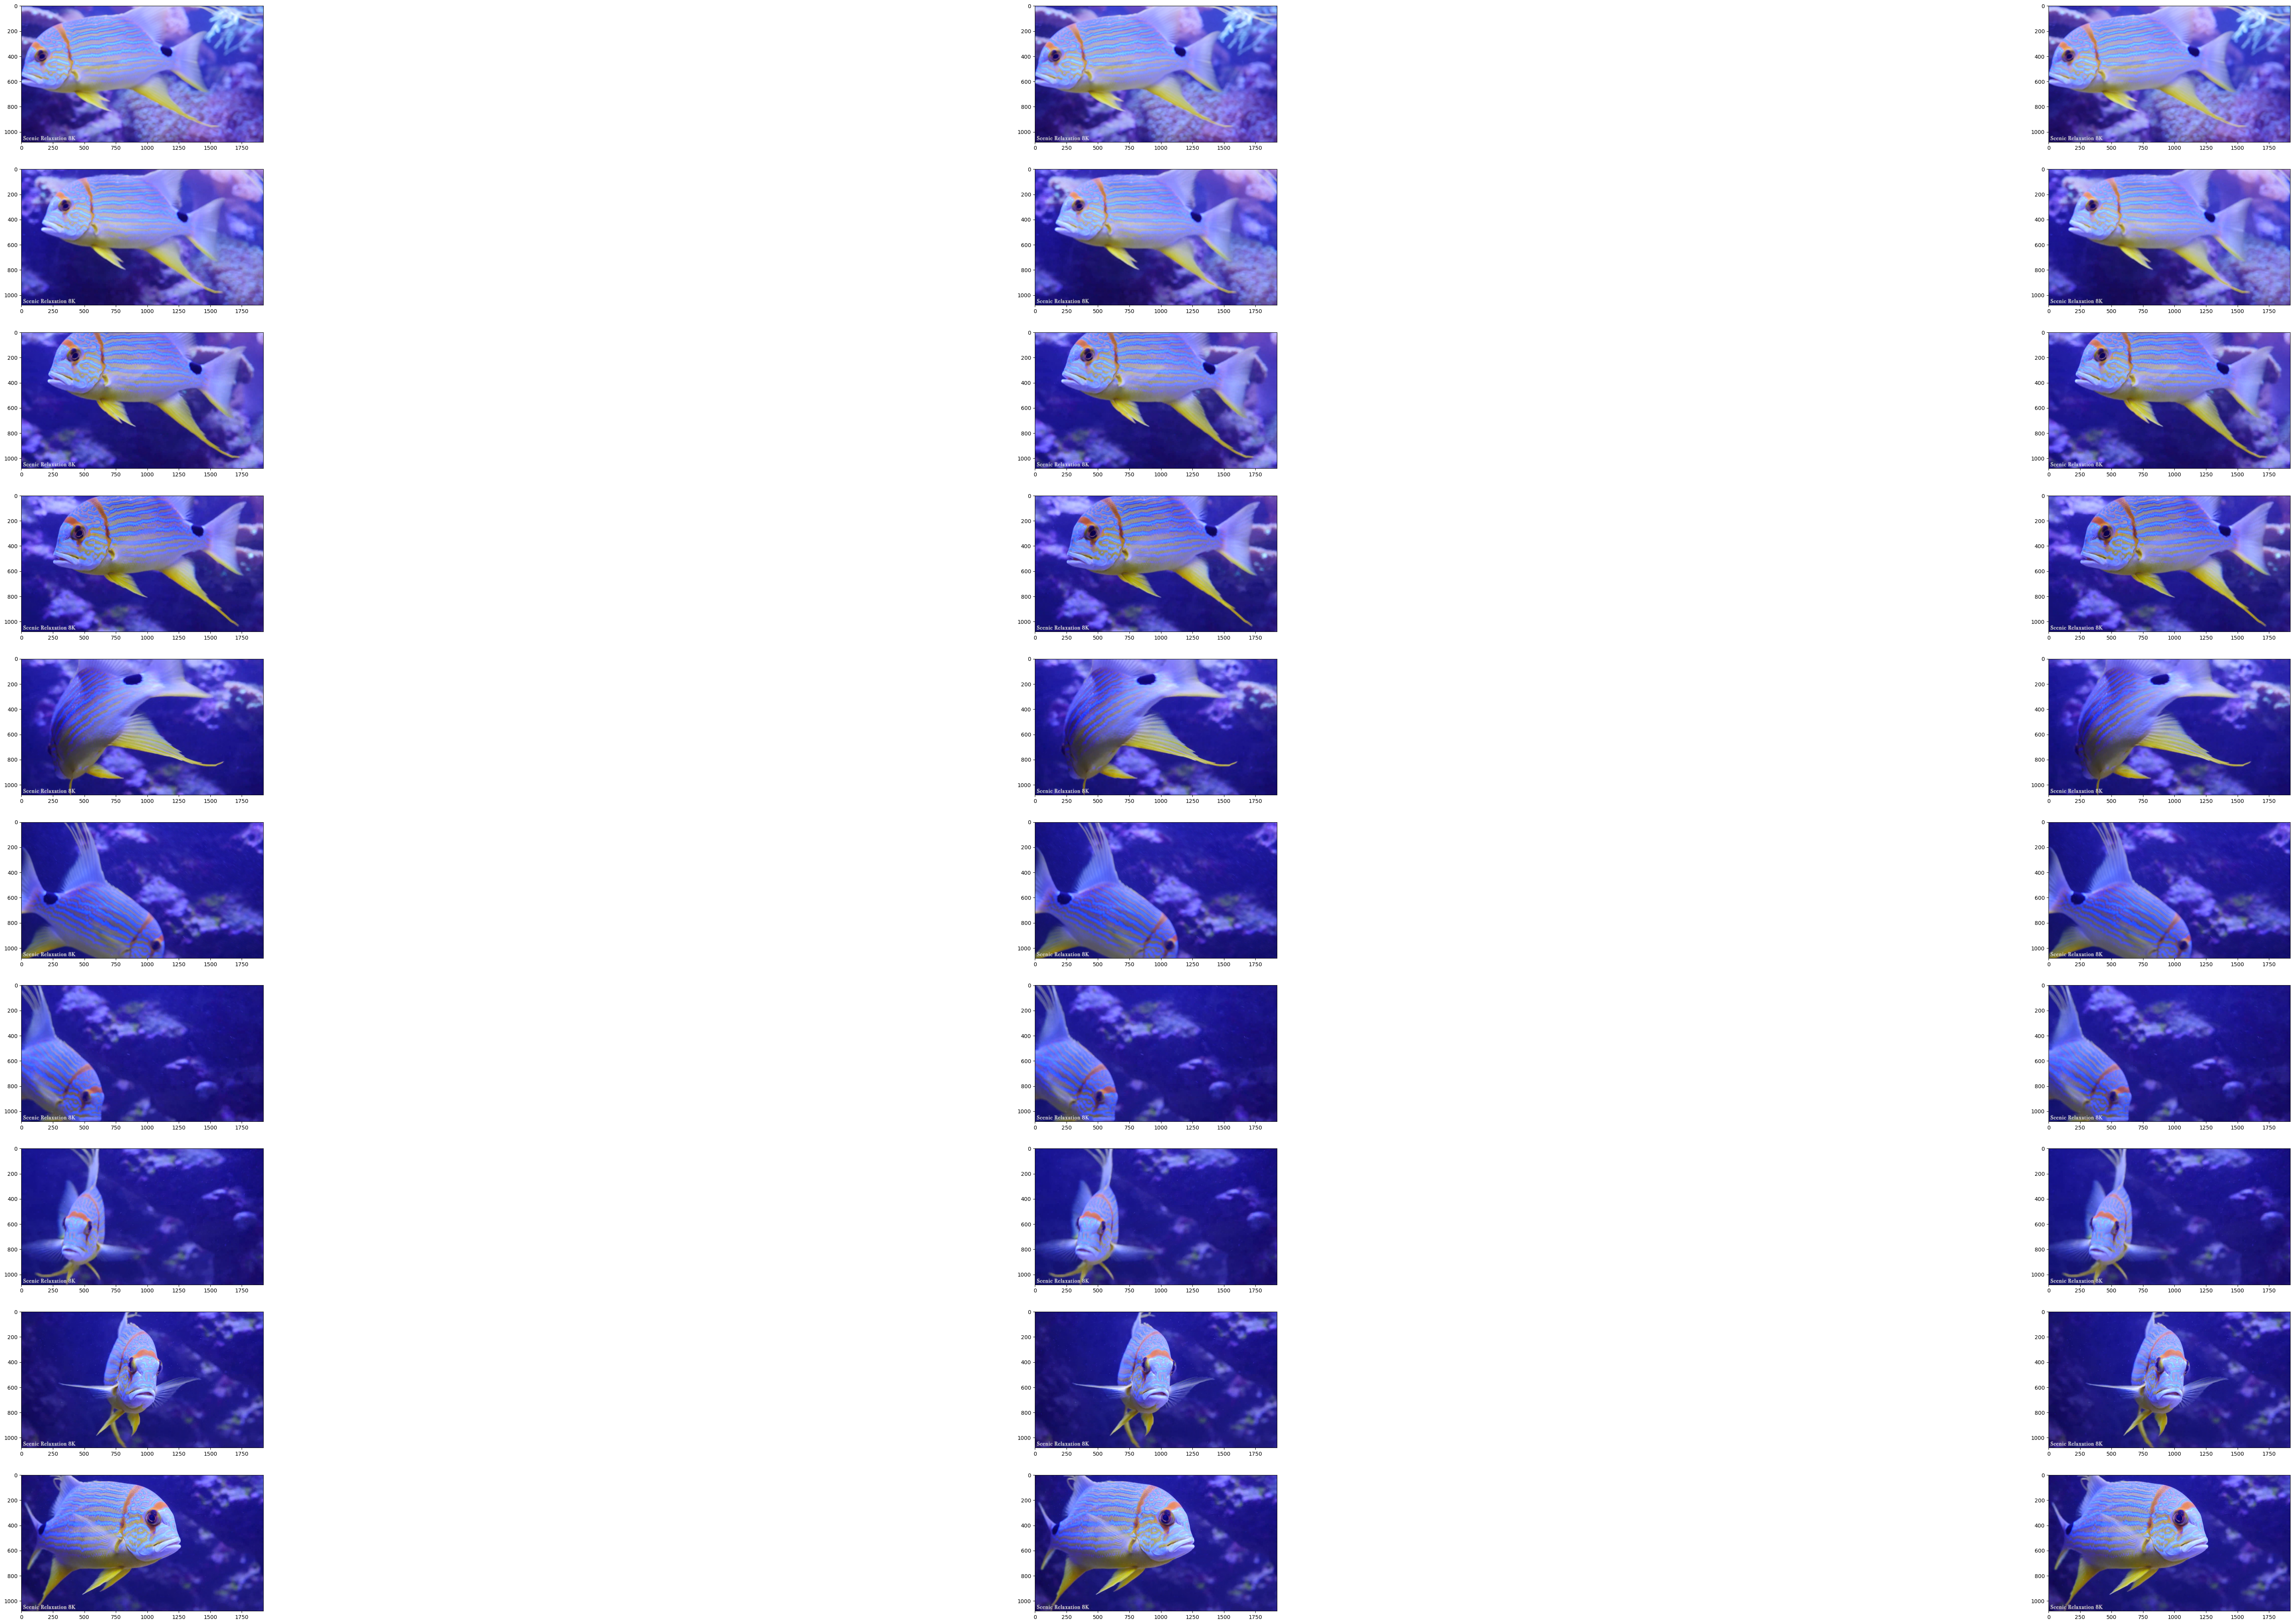

In [103]:
fig, axs = plt.subplots(10, 3, figsize=(96, 54))
for i, frame in enumerate(frames):
    axs[i, 0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axs[i, 1].imshow(cv2.cvtColor(frames2[i], cv2.COLOR_BGR2RGB))
    axs[i, 2].imshow(cv2.cvtColor(frames3[i], cv2.COLOR_BGR2RGB))

# Redis with pickle

In [118]:
import pickle

In [128]:
start_time = time.time()

for i, frame in enumerate(frames):
    encoded = pickle.dumps(frame)    
    r.set(f"xu76US-JqG8_v2:frame_{i}", encoded)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.7930202484130859 seconds ---


In [129]:
start_time = time.time()

frames4 = []
keys = []
for key in r.scan_iter("xu76US-JqG8_v2:*"):
    keys.append(key)

keys = sorted(keys, key=lambda x: int(x.decode('utf-8').split('_')[-1]))

for key in keys:
    encoded = r.get(key)
    frames4.append(pickle.loads(encoded))
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.6728754043579102 seconds ---
